# Alignment optimisation

## 1 Setup

Flags

In [1]:
# None

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
GOLD_ALIGNMENTS = '../../data/alignments/{}/sebastien-lerique.csv'.format(DB_NAME)
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


In [3]:
#import random
import itertools
import csv
import json

import numpy as np
from scipy import optimize
from nltk.metrics import edit_distance
from frozendict import frozendict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
#from mpl_toolkits.mplot3d import Axes3D
from progressbar import ProgressBar

from gists.models import Sentence
from analysis import settings, transformations

## 2 Optimise for hand-coded alignments

### 2.1 Framework setup

In [4]:
gold_sentences = []
gold_alignments = []
with open(GOLD_ALIGNMENTS, 'r') as gold_file:
    reader = csv.DictReader(gold_file)
    for row in reader:
        sentence = Sentence.objects.get(id=row['sentence_id'])
        gold_sentences.append(sentence)
        int_alignment = (json.loads(row['parent_coding']),
                         json.loads(row['sentence_coding']))
        alignment = transformations.int_decode_scoreless_alignment(
            sentence.parent.tokens, sentence.tokens, int_alignment)
        alignment += (0,)
        # One gold alignment per sentence
        gold_alignments.append([alignment])

In [5]:
def alignments(sentences, parameters):
    frozen_parameters = frozendict(parameters)
    return [transformations.align_lemmas(s.parent.tokens, s.tokens,
                                         parameters=frozen_parameters)
            for s in sentences]

In [6]:
def distance(alignment1, alignment2):
    seq1A, seq1B = alignment1[:2]
    seq2A, seq2B = alignment2[:2]
    seq1A = list(map(id, seq1A))
    seq1B = list(map(id, seq1B))
    seq2A = list(map(id, seq2A))
    seq2B = list(map(id, seq2B))
    return (edit_distance(seq1A, seq2A) + edit_distance(seq1B, seq2B)) / 2

In [7]:
BASE_COMPARE_FACTOR = 1
def x2parameters(x):
    return frozendict({
        'COMPARE_FACTOR': BASE_COMPARE_FACTOR,
        'COMPARE_ORIGIN': x[0] * BASE_COMPARE_FACTOR,
        'GAP_OPEN': (x[1] + x[2]) * BASE_COMPARE_FACTOR,
        'GAP_EXTEND': x[2] * BASE_COMPARE_FACTOR,
        'EXCHANGE': None,
    })

def parameters2x(parameters):
    return (np.array([parameters['COMPARE_ORIGIN'],
                      parameters['GAP_OPEN'] - parameters['GAP_EXTEND'],
                      parameters['GAP_EXTEND']])
            / parameters['COMPARE_FACTOR'])

In [8]:
def objective(x, sentences, ref_alignments):
    x_alignments = alignments(sentences, x2parameters(x))
    distances = []
    for ref_as, x_as in zip(ref_alignments, x_alignments):
        if len(x_as) == 0:
            # Add an empty alignment if there are none
            x_as = [([], [])]
        # Or use max+mean
        distances.append(np.max([distance(ref_a, x_a) for ref_a, x_a
                                 in itertools.product(ref_as,  x_as)]))
    return np.sum(distances)

### 2.2 Brute force

#### 2.2.1 On large boundaries, with discretization=10

In [9]:
x_bounds_large = [
    (-1, -.01), # COMPARE_ORIGIN / COMPARE_FACTOR
    (-1, -.01), # (GAP_OPEN - GAP_EXTEND) / COMPARE_FACTOR
    (-1, -.01), # GAP_EXTEND / COMPARE_FACTOR
]
n_dims = len(x_bounds_large)

In [10]:
xs_large = [np.linspace(start, stop, 10)
            for (start, stop) in x_bounds_large]
grids_large = np.meshgrid(*xs_large, indexing='ij')
values_large = np.zeros_like(grids_large[0])

for i, k in ProgressBar(max_value=len(values_large.flat))(
        enumerate(itertools.product(range(len(xs_large[0])), repeat=n_dims))):
    values_large[k] = objective([grids_large[j][k] for j in range(n_dims)],
                                 gold_sentences, gold_alignments)

min_value_large = np.min(values_large)
min_locations_large = np.where(values_large == min_value_large)
print('Min optimisation objective value {}, found in {} points'
      .format(min_value_large, len(min_locations_large[0])))

100% (1000 of 1000) |#####################| Elapsed Time: 0:18:25 Time: 0:18:25


Min optimisation objective value 255.0, found in 3 points


In [11]:
for k in zip(*min_locations_large):
    x = [grids_large[0][k], grids_large[1][k], grids_large[2][k]]
    print(x)
    print(x2parameters(x))
    print()

[-1.0, -0.12, -0.22999999999999998]
<frozendict {'COMPARE_FACTOR': 1, 'COMPARE_ORIGIN': -1.0, 'GAP_OPEN': -0.34999999999999998, 'GAP_EXTEND': -0.22999999999999998, 'EXCHANGE': None}>

[-0.78000000000000003, -0.12, -0.12]
<frozendict {'COMPARE_FACTOR': 1, 'COMPARE_ORIGIN': -0.78000000000000003, 'GAP_OPEN': -0.23999999999999999, 'GAP_EXTEND': -0.12, 'EXCHANGE': None}>

[-0.56000000000000005, -0.12, -0.01]
<frozendict {'COMPARE_FACTOR': 1, 'COMPARE_ORIGIN': -0.56000000000000005, 'GAP_OPEN': -0.13, 'GAP_EXTEND': -0.01, 'EXCHANGE': None}>



Attempting to fine-tune the minima found

In [12]:
for k in zip(*min_locations_large):
    print('Starting at x = ', x)
    result = optimize.minimize(
        objective, [grids_large[0][k], grids_large[1][k], grids_large[2][k]],
        method='SLSQP',
        bounds=x_bounds_large,
        args=(gold_sentences, gold_alignments),
        options={'disp': True, 'maxiter': 500},
        callback=print)
    print(result)
    print(x2parameters(result.x))
    print()
    print()

Starting at x =  [-0.56000000000000005, -0.12, -0.01]
[-1.   -0.12 -0.23]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 255.0
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
     fun: 255.0
     jac: array([ 0.,  0.,  0.])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([-1.  , -0.12, -0.23])
<frozendict {'COMPARE_FACTOR': 1, 'COMPARE_ORIGIN': -1.0, 'GAP_OPEN': -0.34999999999999998, 'GAP_EXTEND': -0.22999999999999998, 'EXCHANGE': None}>


Starting at x =  [-0.56000000000000005, -0.12, -0.01]
[-0.78 -0.12 -0.12]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 255.0
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
     fun: 255.0
     jac: array([ 0.,  0.,  0.])
 message: 'Optimization terminated successfully.'
    nfev: 5
 

Does not seem to work much.

#### 2.2.2 On more restricted boundaries, with discretization=10

In [13]:
x_bounds_small = [
    (-1, -.5), # COMPARE_ORIGIN / COMPARE_FACTOR
    (-.5, -.01), # (GAP_OPEN - GAP_EXTEND) / COMPARE_FACTOR
    (-.5, -.01), # GAP_EXTEND / COMPARE_FACTOR
]

In [14]:
xs_small10 = [np.linspace(start, stop, 10)
              for (start, stop) in x_bounds_small]
grids_small10 = np.meshgrid(*xs_small10, indexing='ij')
values_small10 = np.zeros_like(grids_small10[0])

for i, k in ProgressBar(max_value=len(values_small10.flat))(
        enumerate(itertools.product(range(len(xs_small10[0])), repeat=n_dims))):
    values_small10[k] = objective([grids_small10[j][k] for j in range(n_dims)],
                                   gold_sentences, gold_alignments)

min_value_small10 = np.min(values_small10)
min_locations_small10 = np.where(values_small10 == min_value_small10)
print('Min optimisation objective value {}, found in {} points'
      .format(min_value_small10, len(min_locations_small10[0])))

100% (1000 of 1000) |#####################| Elapsed Time: 0:18:40 Time: 0:18:40


Min optimisation objective value 240.0, found in 1 points


In [15]:
for k in zip(*min_locations_small10):
    x = [grids_small10[0][k], grids_small10[1][k], grids_small10[2][k]]
    print(x)
    print(x2parameters(x))
    print()

[-0.88888888888888884, -0.17333333333333334, -0.11888888888888893]
<frozendict {'COMPARE_FACTOR': 1, 'COMPARE_ORIGIN': -0.88888888888888884, 'GAP_OPEN': -0.29222222222222227, 'GAP_EXTEND': -0.11888888888888893, 'EXCHANGE': None}>



#### 2.2.2 On more restricted boundaries, with discretization=19

Why 19? Because since the ending is included in `np.linspace()`, using 19 gives us exactly the same points as discretisation=10, and all the intermediary points. (Why not use `endpint=False`? I tried it, and this found a better minimum, by chance really.)

In [16]:
xs_small20 = [np.linspace(start, stop, 19)
              for (start, stop) in x_bounds_small]
grids_small20 = np.meshgrid(*xs_small20, indexing='ij')
values_small20 = np.zeros_like(grids_small20[0])

for i, k in ProgressBar(max_value=len(values_small20.flat))(
        enumerate(itertools.product(range(len(xs_small20[0])), repeat=n_dims))):
    values_small20[k] = objective([grids_small20[j][k] for j in range(n_dims)],
                                   gold_sentences, gold_alignments)

min_value_small20 = np.min(values_small20)
min_locations_small20 = np.where(values_small20 == min_value_small20)
print('Min optimisation objective value {}, found in {} points'
      .format(min_value_small20, len(min_locations_small20[0])))

100% (6859 of 6859) |#####################| Elapsed Time: 1:53:25 Time: 1:53:25


Min optimisation objective value 240.0, found in 1 points


In [17]:
for k in zip(*min_locations_small20):
    x = [grids_small20[0][k], grids_small20[1][k], grids_small20[2][k]]
    print(x)
    print(x2parameters(x))
    print()

[-0.88888888888888884, -0.17333333333333334, -0.11888888888888893]
<frozendict {'COMPARE_FACTOR': 1, 'COMPARE_ORIGIN': -0.88888888888888884, 'GAP_OPEN': -0.29222222222222227, 'GAP_EXTEND': -0.11888888888888893, 'EXCHANGE': None}>



### 2.3 Distribution of distances with gold standard for optimal parameters

In [10]:
opt_x = [-0.88888888888888884, -0.17333333333333334, -0.11888888888888893]

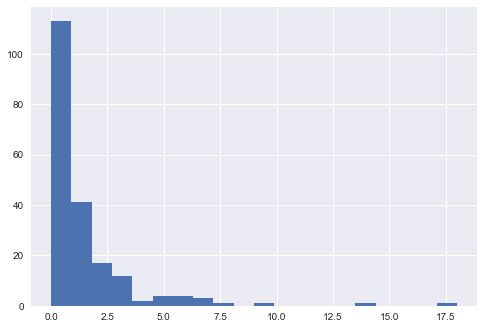

In [15]:
opt_x_alignments = alignments(gold_sentences, x2parameters(opt_x))
distances = []
for ref_as, x_as in zip(gold_alignments, opt_x_alignments):
    if len(x_as) == 0:
        # Add an empty alignment if there are none
        x_as = [([], [])]
    # Or use max+mean
    distances.append(np.max([distance(ref_a, x_a) for ref_a, x_a
                             in itertools.product(ref_as,  x_as)]))
plt.hist(distances, bins=20);